In [59]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

intentional overfitting

In [60]:
# configs and hyperparameters
BATCH_SIZE = 2048
LEARNING_RATE = 0.0003
EPOCHS = 50
INPUT_SHAPE = 784

NEURONS = 1000
LAYERS = 6


if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Found GPU: {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device("cpu")
    print("⚠️ GPU not found. Falling back to CPU.")

Found GPU: AMD Radeon RX 7700 XT


In [61]:
# data prep
data = np.load('fashion_mnist_garments.npz')

x_garments = data['x_garments']
y_garments = data['y_garments']

x_others = data['x_others']
y_others = data['y_others']

labels_garments = np.ones((len(x_garments), 1))
labels_others = np.zeros((len(x_others), 1))

all_x = np.concatenate([x_garments, x_others], axis=0) 
all_y = np.concatenate([labels_garments, labels_others], axis=0)

x_tensor = torch.from_numpy(all_x).float()
y_tensor = torch.from_numpy(all_y).float()

print(f"size of tensor: {x_tensor.shape}")

full_dataset = TensorDataset(x_tensor, y_tensor)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

size of tensor: torch.Size([70000, 28, 28])


In [62]:
class GarmentClassifierOverfit(nn.Module):
    def __init__(self):
        super().__init__()

        # flatten firt
        layers_list = [nn.Flatten()]
        
        # first hidden layer
        layers_list.append(nn.Linear(INPUT_SHAPE, NEURONS))
        layers_list.append(nn.ReLU())

        # deep hidden layers
        for _ in range(LAYERS - 2):
            layers_list.append(nn.Linear(NEURONS, NEURONS))
            layers_list.append(nn.ReLU())
            
        # output layer
        layers_list.append(nn.Linear(NEURONS, 1))
        layers_list.append(nn.Sigmoid())
        
        # unpacking into sequential
        self.layers = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.layers(x)

In [63]:
class Trainer:
    def __init__(self, model, learning_rate, device):
        self.model = model.to(device)
        self.device = device
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # store histories
        self.train_loss_history = []
        self.val_loss_history = []

    def validate(self, val_loader):
        self.model.eval()
        running_loss = 0.0
        with torch.no_grad(): 
            for x, y in val_loader:
                x, y = x.to(self.device), y.to(self.device)
                preds = self.model(x)
                loss = self.loss_fn(preds, y)
                running_loss += loss.item()
        return running_loss / len(val_loader)
    def train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(self.device), y.to(self.device)
            preds = self.model(x)
            loss = self.loss_fn(preds, y)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
        return running_loss / len(train_loader)
    
    def fit(self, train_loader, val_loader, epochs):
        for epoch in range(epochs):
            # train
            train_loss = self.train_epoch(train_loader)
            self.train_loss_history.append(train_loss)
            
            # validate
            val_loss = self.validate(val_loader)
            self.val_loss_history.append(val_loss)
            
            print(f"epoch {epoch+1}/{epochs} | train Loss: {train_loss:.4f} | val Loss: {val_loss:.4f}")
            
        return self.train_loss_history, self.val_loss_history

In [64]:
model = GarmentClassifierOverfit().to(DEVICE)
trainer = Trainer(model, LEARNING_RATE, DEVICE)

# train
print(f"training with {LAYERS} layers and {NEURONS} neurons...")

t_hist, v_hist = trainer.fit(train_loader, val_loader, EPOCHS)

training with 6 layers and 1000 neurons...
epoch 1/50 | train Loss: 0.0753 | val Loss: 0.0196
epoch 2/50 | train Loss: 0.0182 | val Loss: 0.0162
epoch 3/50 | train Loss: 0.0149 | val Loss: 0.0133
epoch 4/50 | train Loss: 0.0120 | val Loss: 0.0111
epoch 5/50 | train Loss: 0.0100 | val Loss: 0.0107
epoch 6/50 | train Loss: 0.0095 | val Loss: 0.0113
epoch 7/50 | train Loss: 0.0080 | val Loss: 0.0096
epoch 8/50 | train Loss: 0.0079 | val Loss: 0.0116
epoch 9/50 | train Loss: 0.0081 | val Loss: 0.0085
epoch 10/50 | train Loss: 0.0065 | val Loss: 0.0073
epoch 11/50 | train Loss: 0.0055 | val Loss: 0.0070
epoch 12/50 | train Loss: 0.0073 | val Loss: 0.0094
epoch 13/50 | train Loss: 0.0071 | val Loss: 0.0071
epoch 14/50 | train Loss: 0.0050 | val Loss: 0.0072
epoch 15/50 | train Loss: 0.0044 | val Loss: 0.0065
epoch 16/50 | train Loss: 0.0041 | val Loss: 0.0066
epoch 17/50 | train Loss: 0.0047 | val Loss: 0.0076
epoch 18/50 | train Loss: 0.0040 | val Loss: 0.0065
epoch 19/50 | train Loss: 0.00

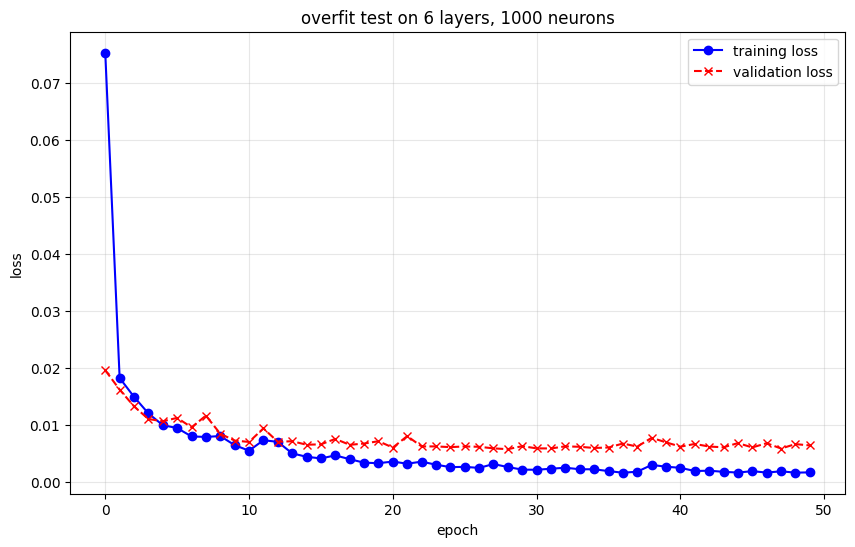

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(t_hist, marker='o', label='training loss', color='blue')
plt.plot(v_hist, marker='x', label='validation loss', color='red', linestyle='--')
plt.title(f'overfit test on {LAYERS} layers, {NEURONS} neurons')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

l1 l2 regularization and dropout implementation

In [70]:
class RegularizedTrainer:
    def __init__(self, model, learning_rate, device, l1_lambda=0.0, l2_lambda=0.0):
        self.model = model.to(device)
        self.device = device
        self.loss_fn = nn.MSELoss()

        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.train_loss_history = []
        self.val_loss_history = []

    def train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        
        for x, y in train_loader:
            x, y = x.to(self.device), y.to(self.device)
            preds = self.model(x)
            
            # base loss
            loss = self.loss_fn(preds, y)
            
            # l1 regularization (sum of absolute weights)
            if self.l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in self.model.parameters()) 
                loss = loss + self.l1_lambda * l1_norm 
                
            # l2 regularization (sum of squared weights)
            if self.l2_lambda > 0:
                l2_norm = sum((p**2).sum() for p in self.model.parameters()) 
                loss = loss + self.l2_lambda * l2_norm 

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / len(train_loader)

    def validate(self, val_loader):
        self.model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(self.device), y.to(self.device)
                preds = self.model(x)
                loss = self.loss_fn(preds, y)
                running_loss += loss.item()
        return running_loss / len(val_loader)
    
    def fit(self, train_loader, val_loader, epochs):
        print(f"Training with L1={self.l1_lambda}, L2={self.l2_lambda}...")
        for epoch in range(epochs):
            t_loss = self.train_epoch(train_loader)
            v_loss = self.validate(val_loader)
            self.train_loss_history.append(t_loss)
            self.val_loss_history.append(v_loss)
            
            if (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Train: {t_loss:.4f} | Val: {v_loss:.4f}")
        return self.train_loss_history, self.val_loss_history

Training with L1=1e-06, L2=0...
Epoch 5/50 | Train: 0.0557 | Val: 0.0126
Epoch 10/50 | Train: 0.0435 | Val: 0.0086
Epoch 15/50 | Train: 0.0365 | Val: 0.0066
Epoch 20/50 | Train: 0.0312 | Val: 0.0062
Epoch 25/50 | Train: 0.0272 | Val: 0.0058
Epoch 30/50 | Train: 0.0241 | Val: 0.0068
Epoch 35/50 | Train: 0.0203 | Val: 0.0057
Epoch 40/50 | Train: 0.0182 | Val: 0.0057
Epoch 45/50 | Train: 0.0164 | Val: 0.0063
Epoch 50/50 | Train: 0.0141 | Val: 0.0056


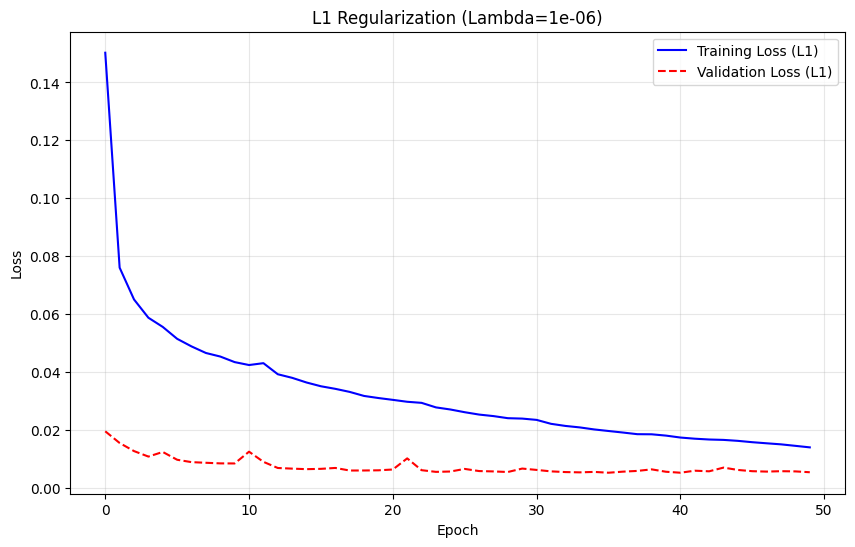

In [ ]:

model_l1 = GarmentClassifierOverfit()

# 1e-4 was too high, caused underfitting
lambda_1 = 1e-6

trainer_l1 = RegularizedTrainer(model_l1, LEARNING_RATE, DEVICE, l1_lambda=lambda_1, l2_lambda=0)
l1_train, l1_val = trainer_l1.fit(train_loader, val_loader, EPOCHS)

# viz
plt.figure(figsize=(10, 6))
plt.plot(l1_train, label='training loss (L1)', color='blue')
plt.plot(l1_val, label='validation loss (L1)', color='red', linestyle='--')
plt.title(f'L1 regularization (lambda={lambda_1})')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training with L1=0, L2=0.0001...
Epoch 5/50 | Train: 0.0711 | Val: 0.0102
Epoch 10/50 | Train: 0.0489 | Val: 0.0089
Epoch 15/50 | Train: 0.0339 | Val: 0.0068
Epoch 20/50 | Train: 0.0260 | Val: 0.0064
Epoch 25/50 | Train: 0.0205 | Val: 0.0104
Epoch 30/50 | Train: 0.0166 | Val: 0.0074
Epoch 35/50 | Train: 0.0145 | Val: 0.0072
Epoch 40/50 | Train: 0.0131 | Val: 0.0062
Epoch 45/50 | Train: 0.0100 | Val: 0.0066
Epoch 50/50 | Train: 0.0097 | Val: 0.0058


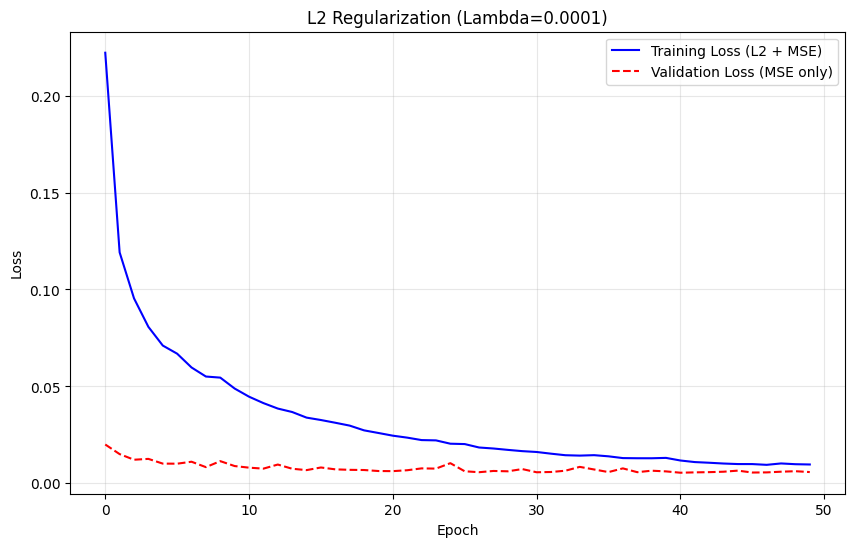

In [ ]:

model_l2 = GarmentClassifierOverfit()

lambda_2 = 1e-4 

trainer_l2 = RegularizedTrainer(model_l2, LEARNING_RATE, DEVICE, l1_lambda=0, l2_lambda=lambda_2)
l2_train, l2_val = trainer_l2.fit(train_loader, val_loader, EPOCHS)

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(l2_train, label='training loss (L2 + MSE)', color='blue')
plt.plot(l2_val, label='validation loss (MSE only)', color='red', linestyle='--')
plt.title(f'L2 regularization (lambda={lambda_2})')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training with L1=0.0, L2=0.0...
Epoch 5/50 | Train: 0.0144 | Val: 0.0126
Epoch 10/50 | Train: 0.0087 | Val: 0.0086
Epoch 15/50 | Train: 0.0066 | Val: 0.0075
Epoch 20/50 | Train: 0.0061 | Val: 0.0070
Epoch 25/50 | Train: 0.0052 | Val: 0.0067
Epoch 30/50 | Train: 0.0044 | Val: 0.0066
Epoch 35/50 | Train: 0.0041 | Val: 0.0062
Epoch 40/50 | Train: 0.0041 | Val: 0.0062
Epoch 45/50 | Train: 0.0038 | Val: 0.0063
Epoch 50/50 | Train: 0.0036 | Val: 0.0061


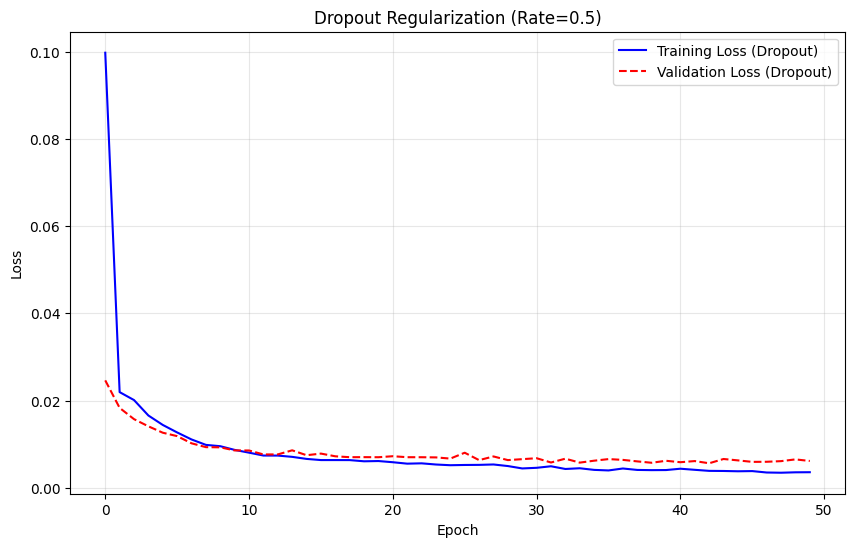

In [ ]:
class GarmentClassifierDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        layers_list = [nn.Flatten()]
        
        # input layer
        layers_list.append(nn.Linear(INPUT_SHAPE, NEURONS))
        layers_list.append(nn.ReLU())
        layers_list.append(nn.Dropout(dropout_rate)) 
        
        # hidden layers
        for _ in range(LAYERS - 2):
            layers_list.append(nn.Linear(NEURONS, NEURONS))
            layers_list.append(nn.ReLU())
            layers_list.append(nn.Dropout(dropout_rate)) 
            
        # output layer
        layers_list.append(nn.Linear(NEURONS, 1))
        layers_list.append(nn.Sigmoid())
        
        self.layers = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.layers(x)

# run with dropout
model_dropout = GarmentClassifierDropout(dropout_rate=0.5)
trainer_drop = RegularizedTrainer(model_dropout, LEARNING_RATE, DEVICE) 

drop_train, drop_val = trainer_drop.fit(train_loader, val_loader, EPOCHS)

# viz
plt.figure(figsize=(10, 6))
plt.plot(drop_train, label='Training Loss (Dropout)', color='blue')
plt.plot(drop_val, label='Validation Loss (Dropout)', color='red', linestyle='--')
plt.title(f'Dropout Regularization (Rate=0.5)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()